In [1]:
import sys
import numpy as np
import xarray as xr
from scipy.io import loadmat
from datetime import datetime
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib as mpl
sys.path.append('/Users/jakesteinberg/ECCOv4-py/ECCOv4-py')
import ecco_v4_py as ecco
from xgcm import Grid 
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
# -- ECCO GRIDS -- 
# base_dir = '/home/username/'
base_dir = '/Users/jakesteinberg/Documents/NASA_OSTST/ECCO/'
## define a high-level directory for ECCO fields
ECCO_dir = base_dir + '/v5'
## Load the model grid
grid_dir= ECCO_dir + '/nctiles_grid/'
# ecco_grid = ecco.load_ecco_grid_nc(grid_dir, 'ECCOv4r3_grid.nc', k_subset=[0])
ecco_grid = ecco.load_ecco_grid_nc(grid_dir, 'ECCO-GRID.nc')
data_dir= ECCO_dir + '/nctiles_monthly'  
ecco_daily_vars = ecco.recursive_load_ecco_var_from_years_nc(data_dir,vars_to_load=['ETAN', 'PHIBOT'],\
                                           years_to_load=range(2008,2018)).load()    
## Merge the ecco_grid with the ecco_vars to make the ecco_ds
ecco_monthly_ds = xr.merge((ecco_grid , ecco_daily_vars))
# build grid object 
metrics = {
    ('X',): ['dxC', 'dxG'], # X distances
    ('Y',): ['dyC', 'dyG'], # Y distances
    ('X', 'Y'): ['rA', 'rAz', 'rAs', 'rAw'] # Areas
}
# XC distance from grid center point to center point 
# XG distance from grid egde (where u is defined) to grid edge (finite difference of values at XC will be placed here)
grid = Grid(ecco_monthly_ds, metrics=metrics)

# bathymetry
tile_num=10
lon_range = [-98, -78]; lat_range = [17, 31] 
lons = ecco_grid.XC.sel(tile=tile_num)
lats = ecco_grid.YC.sel(tile=tile_num)

loading files of  ETAN
loading files of  PHIBOT


In [3]:
# -- ECCO --  
# bathymetry
dep = ecco_monthly_ds.Depth
dep = dep.where(ecco_monthly_ds.hFacC.isel(tile=tile_num,k=0) !=0, np.nan)

In [4]:
# --- ECCO --- 
g = 9.81
rho0=1029

# -- MASK -- at the surface and total ocean area 
ocean_mask = np.ceil(ecco_monthly_ds.hFacC[0])
ocean_mask = ocean_mask.where(ocean_mask==1, np.nan)
total_ocean_area = np.sum(ecco_monthly_ds.rA*ocean_mask)

# -- OBP -- 
# (2008-2017)
obp_cor = 1029*(ecco_monthly_ds.PHIBOT + g*dep) # calculate OBP following ECCO code 
OBP_global_mean_mon = (obp_cor*ecco_monthly_ds.rA).sum(dim=['i','j','tile'])/total_ocean_area # global mean time series 
obp_mgm = obp_cor - OBP_global_mean_mon      # subtract global spatial mean time series 
# obp_anom = obp_mgm - obp_mgm.mean(dim='time')  # subtract time mean at each point 
obp_anom = obp_cor - obp_cor.mean(dim='time')  # subtract time mean at each point 
pobp = obp_anom.polyfit(dim='time', deg=1)
# eobp_trend = pobp.polyfit_coefficients.isel(degree=0)*1e9*60*60*24*365 

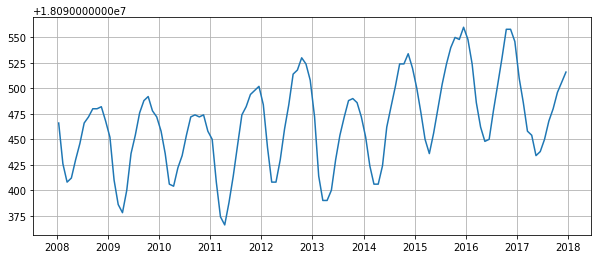

In [5]:
f, ax = plt.subplots(1,1,figsize=(10,4))
ax.plot(OBP_global_mean_mon.time,OBP_global_mean_mon)
ax.grid()

In [6]:
# -- GOM MASK -- 
gulf_mask_f = xr.open_dataset('/Users/jakesteinberg/Documents/NASA_OSTST/ecco_gulf_mask_4.nc')
mask_lon = gulf_mask_f.XC # gulf_mask.lon.data + 360
mask_lat = gulf_mask_f.YC # gulf_mask.lat.data 
gulf_mask = gulf_mask_f.hFacC

(17.0, 31.0)

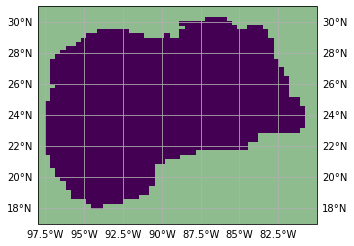

In [7]:
lon_w = -98; lon_e = -80; lat_s = 17; lat_n = 31; 
f, ax = plt.subplots(1,1,figsize=(6,4), subplot_kw={'projection':ccrs.PlateCarree(central_longitude=0)})
ax.pcolor(lons, lats, gulf_mask, transform=ccrs.PlateCarree()); ax.grid(); 
# ax.add_feature(cartopy.feature.LAND, color='#D2B48C',zorder=1); ax.coastlines()
gl = ax.gridlines(draw_labels=True); gl.xlabels_top = False;
ax.set_facecolor('#8FBC8F'); ax.set_xlim([lon_w, lon_e]); ax.set_ylim([lat_s, lat_n])

In [8]:
# --- ECCO --- 
# -- extract linear OBP trend (from OBP anomaly (subtracted global mean time series and local time mean)
# -- remove GOM mean trend (import of mass into basin)
fitloc = pobp.polyfit_coefficients.isel(degree=0).isel(tile=tile_num)*1e9*60*60*24*365/g/rho0
gulf_area = np.nansum(gulf_mask.data*ecco_monthly_ds.rA.isel(tile=tile_num))
mean_gulf_trend = np.nansum(fitloc*gulf_mask.data*ecco_monthly_ds.rA.isel(tile=tile_num))/gulf_area 
gulf_t_obp = fitloc*gulf_mask
gulf_a_obp = gulf_t_obp - mean_gulf_trend
print(mean_gulf_trend)

0.0037074808642112546


In [9]:
gulf_area

1515255500000.0

(17.0, 31.0)

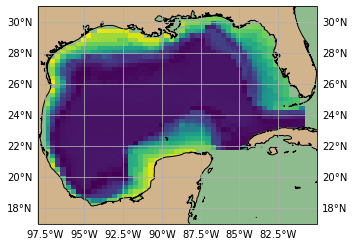

In [10]:
# PLOT mask 
f, ax = plt.subplots(1,1,figsize=(6,4), subplot_kw={'projection':ccrs.PlateCarree(central_longitude=0)})
ax.pcolor(lons, lats, gulf_a_obp, transform=ccrs.PlateCarree()); ax.grid(); 
ax.add_feature(cartopy.feature.LAND, color='#D2B48C',zorder=1); ax.coastlines()
gl = ax.gridlines(draw_labels=True); gl.xlabels_top = False;
ax.set_facecolor('#8FBC8F'); ax.set_xlim([lon_w, lon_e]); ax.set_ylim([lat_s, lat_n])

In [9]:
# obs 2002-2021
grace = xr.open_dataset('/Users/jakesteinberg/Documents/NASA_OSTST/GRACE/GRCTellus.JPL.200204_202201.GLO.RL06M.MSCNv02CRI.nc')

In [10]:
mascon = xr.open_dataset('/Users/jakesteinberg/Documents/NASA_OSTST/GRACE/JPL_MSCNv02_PLACEMENT.nc')

In [11]:
m_lon = mascon.mascon_lon.data
m_lat = mascon.mascon_lat.data
# m_lon_e1 = np.diff(m_lon)/2 + m_lon[0:-1]
# m_lat_e1 = np.diff(m_lat)/2 + m_lat[0:-1]
corners = np.nan*np.ones((len(m_lon), 4))
for i in range(len(m_lon)):
    this_lat = m_lat[i]    
    this_lon = m_lon[i]
    this_lon_lb = m_lon[m_lat == this_lat] # give me only lons at this lat band 
    
    lat_plus = np.where(m_lat > this_lat)[0]
    lat_minus = np.where(m_lat < this_lat)[0]
    
    lon_plus = np.where(this_lon_lb > this_lon)[0]
    lon_minus = np.where(this_lon_lb < this_lon)[0]
    
    if len(lon_minus) > 0:
        corners[i,0] = np.nanmax(this_lon_lb[lon_minus]) # left
    if len(lon_plus) > 0:
        corners[i,1] = np.nanmin(this_lon_lb[lon_plus]) # right
    if len(lat_minus) > 0:
        corners[i,2] = np.nanmax(m_lat[lat_minus]) # bottom
    if len(lat_plus) > 0:
        corners[i,3] = np.nanmin(m_lat[lat_plus]) # top 

In [12]:
lon_range = np.where((m_lon > 260) & (m_lon < 281))
m_lon_1 = m_lon[lon_range]
m_lat_1 = m_lat[lon_range]
corners_1 = corners[lon_range]
lat_range = np.where((m_lat_1 > 17) & (m_lat_1 < 31))
m_lon_2 = m_lon_1[lat_range]
m_lat_2 = m_lat_1[lat_range]
corners_2 = corners_1[lat_range]

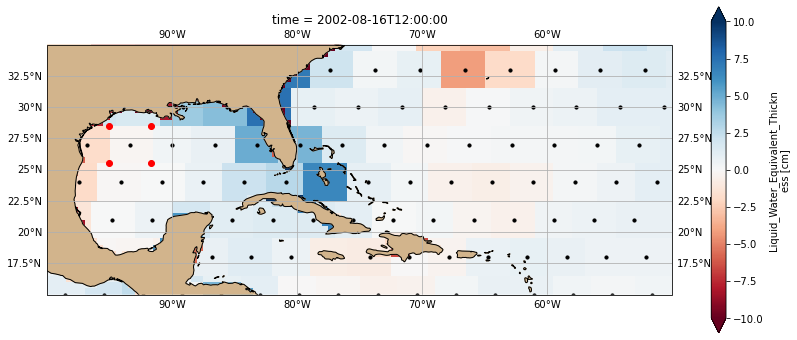

In [13]:
f, ax = plt.subplots(1,1,figsize=(14,6), subplot_kw={'projection':ccrs.PlateCarree(central_longitude=0)})
this_data = grace.lwe_thickness[2]
this_data.plot(ax=ax,transform=ccrs.PlateCarree(), vmin=-10, vmax=10, cmap=plt.get_cmap('RdBu'))
ax.scatter(mascon.mascon_lon,mascon.mascon_lat,s=10,transform=ccrs.PlateCarree(), color='k')
ax.scatter(m_lon_2[1],m_lat_2[1],s=20,transform=ccrs.PlateCarree(), color='g')
ib = np.arange(0,np.shape(corners_2)[0])
box = np.nan*np.ones(np.shape(corners_2))
for i in ib:
    box[i,0] = m_lon_2[i] - (m_lon_2[i] - corners_2[i,0])/2 # left
    box[i,1] = m_lon_2[i] + (corners_2[i,1] - m_lon_2[i])/2 # right
    box[i,2] = m_lat_2[i] - (m_lat_2[i] - corners_2[i,2])/2 # lower
    box[i,3] = m_lat_2[i] + (corners_2[i,3] - m_lat_2[i])/2 # upper
p_i = 7
ax.scatter(box[p_i,0],box[p_i,2],color='r') # lon left 
ax.scatter(box[p_i,1],box[p_i,2],color='r') # lon_right
ax.scatter(box[p_i,0],box[p_i,3],color='r')
ax.scatter(box[p_i,1],box[p_i,3],color='r')
# ax.scatter(m_lon_e1, m_lat_e1, s=2,transform=ccrs.PlateCarree(),color='m')
ax.add_feature(cartopy.feature.LAND, color='#D2B48C',zorder=1); ax.coastlines()
ax.set_ylim([15,35]); ax.set_xlim([-100,-50])
gl = ax.gridlines(draw_labels=True); 

In [14]:
# -- GRACE -- 
# - ecco overlap - 
gobp = grace.lwe_thickness.sel(time=slice("2008-01-01", "2017-12-31"))/100
gobp = gobp - gobp.mean(dim='time')       # temporal anomaly    
pgobp = gobp.polyfit(dim='time', deg=1)
gobp_trend = pgobp.polyfit_coefficients.isel(degree=0)*1e9*60*60*24*365 
# - obs period of interest 
gobp2 = grace.lwe_thickness.sel(time=slice("2010-01-01", "2019-12-31"))/100
gobp2 = gobp2 - gobp2.mean(dim='time')    # temporal anomaly 
pgobp2 = gobp2.polyfit(dim='time', deg=1)
gobp2_trend = pgobp2.polyfit_coefficients.isel(degree=0)*1e9*60*60*24*365

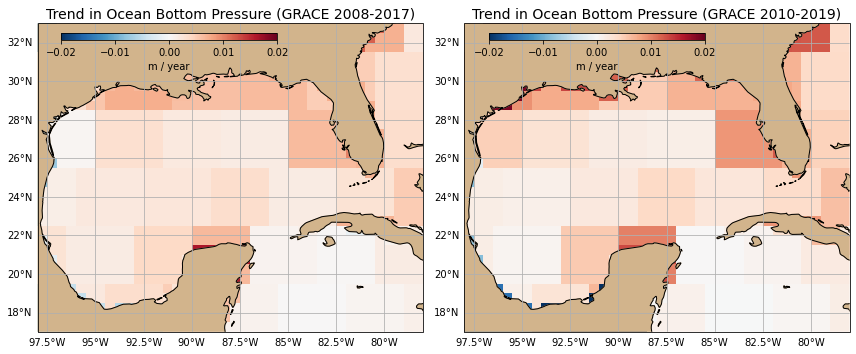

In [81]:
lon_w = -98; lon_e = -78; lat_s = 17; lat_n = 33; 
f, (ax,ax2) = plt.subplots(1,2,figsize=(12,5), subplot_kw={'projection':ccrs.PlateCarree(central_longitude=0)})
cc = gobp_trend.plot(ax=ax,transform=ccrs.PlateCarree(), vmin=-0.02, vmax=0.02, cmap=plt.get_cmap('RdBu_r'),add_colorbar=False)
ax.set_title('Trend in Ocean Bottom Pressure (GRACE 2008-2017)',fontsize=14)
ax.add_feature(cartopy.feature.LAND, color='#D2B48C',zorder=1); ax.coastlines()
gl = ax.gridlines(draw_labels=True); gl.ylabels_right = False; gl.xlabels_top = False;
ax.set_xlim([lon_w, lon_e]); ax.set_ylim([lat_s, lat_n])

cc = gobp2_trend.plot(ax=ax2,transform=ccrs.PlateCarree(), vmin=-0.02, vmax=0.02, cmap=plt.get_cmap('RdBu_r'),add_colorbar=False)
ax2.set_title('Trend in Ocean Bottom Pressure (GRACE 2010-2019)',fontsize=14)
ax2.add_feature(cartopy.feature.LAND, color='#D2B48C',zorder=1); ax2.coastlines()
gl = ax2.gridlines(draw_labels=True); gl.ylabels_right = False; gl.xlabels_top = False;
ax2.set_xlim([lon_w, lon_e]); ax2.set_ylim([lat_s, lat_n])

cbpos = [0.075, 0.88, 0.25, 0.02]; cax = f.add_axes(cbpos); 
cb = f.colorbar(cc, cax=cax, orientation='horizontal', label='m / year')
cbpos = [0.57, 0.88, 0.25, 0.02]; cax = f.add_axes(cbpos); 
cb = f.colorbar(cc, cax=cax, orientation='horizontal', label='m / year')
ax.grid(); plt.tight_layout()
# f.savefig('/Users/jakesteinberg/Documents/NASA_OSTST/manuscript/figures/grace_obp_trend.jpg', dpi=250)

In [15]:
# GRACE sub-domain (for faster run times)
lat_in = np.where((grace.lat < 31) & (grace.lat >18))[0]
lon_in = np.where((grace.lon > (360-97.5)) & (grace.lon < (360-81)))[0]
gobp_trend_sub = gobp_trend[lat_in,lon_in]                                       # trend over time period 1
gobp2_trend_sub = gobp2_trend[lat_in,lon_in]                                     # trend over time period 2 
gobp2_timeseries_sub = gobp2[:,lat_in][:,:,lon_in]                               # obp time series over time period 2 

In [16]:
# define GOM mask and depths on GRACE grid 
mask_lon_r = np.nanmean(mask_lon,axis=1) + 360
mask_lat_r = np.nanmean(mask_lat,axis=0)
gulf_mask_to_g = np.transpose(gulf_mask.data)
dep_t = dep.isel(tile=tile_num)
mask_val = np.nan*np.ones(np.shape(gobp_trend_sub))
mask_dep = np.nan*np.ones(np.shape(gobp_trend_sub))
for i in range(np.shape(gobp_trend_sub)[0]):
    for j in range(np.shape(gobp_trend_sub)[1]):
        this_lon = gobp_trend_sub.lon[j].data
        this_lat = gobp_trend_sub.lat[i].data
        mask_lon_in = np.where((mask_lon_r > (this_lon-0.2)) & (mask_lon_r < (this_lon+0.2)))[0][0]
        mask_lat_in = np.where((mask_lat_r > (this_lat-0.2)) & (mask_lat_r < (this_lat+0.2)))[0][0]
        # mask_val[i,j] = gulf_mask.__xarray_dataarray_variable__[mask_lat_in,mask_lon_in].data
        mask_val[i,j] = gulf_mask_to_g[mask_lat_in,mask_lon_in]
        # if gulf_mask.__xarray_dataarray_variable__[mask_lat_in,mask_lon_in].data > 0:
        #     print('1')
        
        mask_in = np.where((lons.data+360 > (this_lon-0.15)) & (lons.data+360 < (this_lon+0.15)) & \
                           (lats.data > (this_lat-0.15)) & (lats.data < (this_lat+0.15)))
        mask_dep[i,j] = np.nanmean(dep_t[mask_in].data)
mask_dep = mask_dep*mask_val

(17.0, 31.0)

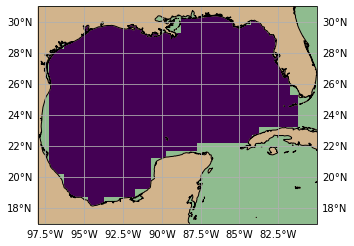

In [17]:
# PLOT mask (CHECK)
f, ax = plt.subplots(1,1,figsize=(6,4), subplot_kw={'projection':ccrs.PlateCarree(central_longitude=0)})
ax.pcolor(gobp_trend_sub.lon, gobp_trend_sub.lat, mask_val, transform=ccrs.PlateCarree()); ax.grid(); 
ax.add_feature(cartopy.feature.LAND, color='#D2B48C',zorder=1); ax.coastlines()
gl = ax.gridlines(draw_labels=True); gl.xlabels_top = False;
ax.set_facecolor('#8FBC8F'); ax.set_xlim([lon_w, lon_e]); ax.set_ylim([lat_s, lat_n])

(17.0, 31.0)

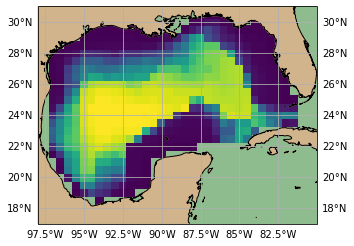

In [126]:
# PLOT mask 
f, ax = plt.subplots(1,1,figsize=(6,4), subplot_kw={'projection':ccrs.PlateCarree(central_longitude=0)})
ax.pcolor(gobp_trend_sub.lon, gobp_trend_sub.lat, mask_dep, transform=ccrs.PlateCarree()); ax.grid(); 
ax.add_feature(cartopy.feature.LAND, color='#D2B48C',zorder=1); ax.coastlines()
gl = ax.gridlines(draw_labels=True); gl.xlabels_top = False;
ax.set_facecolor('#8FBC8F'); ax.set_xlim([lon_w, lon_e]); ax.set_ylim([lat_s, lat_n])

In [18]:
# define OBP anomaly (remove GOM area mean using GOM mask) (time series)
gobp_ts_sub_mask = gobp2_timeseries_sub*mask_val - (gobp2_timeseries_sub*mask_val).mean(dim=['lat','lon']) # OBP after removing basin mean 

(17.0, 31.0)

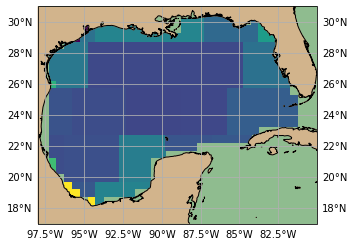

In [24]:
# check mask extend
test = gobp2_timeseries_sub*mask_val
f, ax = plt.subplots(1,1,figsize=(6,4), subplot_kw={'projection':ccrs.PlateCarree(central_longitude=0)})
ax.pcolor(gobp_trend_sub.lon, gobp_trend_sub.lat, test[10], transform=ccrs.PlateCarree()); ax.grid(); 
ax.add_feature(cartopy.feature.LAND, color='#D2B48C',zorder=1); ax.coastlines()
gl = ax.gridlines(draw_labels=True); gl.xlabels_top = False;
ax.set_facecolor('#8FBC8F'); ax.set_xlim([lon_w, lon_e]); ax.set_ylim([lat_s, lat_n])

(17.0, 31.0)

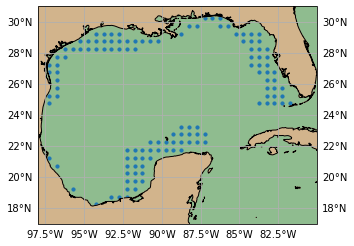

In [19]:
# visualize obp points selected in a desired depth range (for time series as a function of depth)
depth_i = 100
depth_j = 4000
desired_dep = np.where((mask_dep <= depth_i) & (mask_dep > 10))
all_dep = np.where((mask_dep <= depth_j) & (mask_dep > 10))
G_lon, G_lat = np.meshgrid(gobp_trend_sub.lon, gobp_trend_sub.lat)

# PLOT desired depths 
f, ax = plt.subplots(1,1,figsize=(6,4), subplot_kw={'projection':ccrs.PlateCarree(central_longitude=0)})
ax.scatter(G_lon[desired_dep], G_lat[desired_dep], s=10, transform=ccrs.PlateCarree()); ax.grid(); # mask_dep[desired_dep]
ax.add_feature(cartopy.feature.LAND, color='#D2B48C',zorder=1); ax.coastlines()
gl = ax.gridlines(draw_labels=True); gl.xlabels_top = False;
ax.set_facecolor('#8FBC8F'); ax.set_xlim([lon_w, lon_e]); ax.set_ylim([lat_s, lat_n])

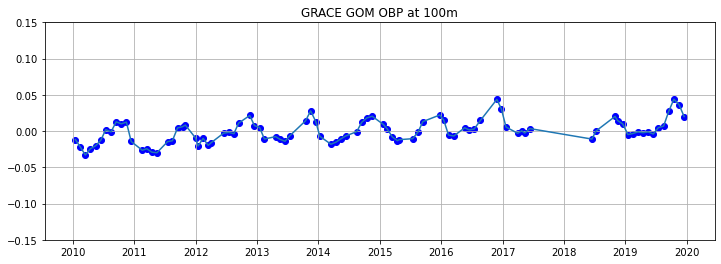

In [20]:
obp_d_i = np.nan*np.ones(len(gobp2.time))
f, ax = plt.subplots(1,1,figsize=(12,4))
for i in range(len(gobp2.time)):
    obp_d_i[i] = np.nanmean(gobp_ts_sub_mask[i].data[desired_dep])
ax.plot(gobp2.time,obp_d_i)
ax.scatter(gobp2.time,obp_d_i,color='b')
ax.set_title('GRACE GOM OBP at ' + str(depth_i) + 'm')
ax.set_ylim([-0.15,0.15])
ax.grid()

In [191]:
# SAVE  
grace_obp_a = xr.Dataset(
    data_vars=dict(
        grace_obp = (['time'], obp_d_i),
    ),
    coords=dict(
        time=(["time"], gobp2.time.data)
    ),
)
grace_obp_a.to_netcdf(path='/Users/jakesteinberg/Documents/NASA_OSTST/grace_obp_100m_2010_2019.nc')

In [27]:
# depth grid on which to define GRACE OBP time series 
depths = -1*np.array([   -5.   ,   -15.   ,   -25.   ,   -35.   ,   -45.   ,   -55.   ,
         -65.   ,   -75.005,   -85.025,   -95.095,  -105.31 ,  -115.87 ,
        -127.15 ,  -139.74 ,  -154.47 ,  -172.4  ,  -194.735,  -222.71 ,
        -257.47 ,  -299.93 ,  -350.68 ,  -409.93 ,  -477.47 ,  -552.71 ,
        -634.735,  -722.4  ,  -814.47 ,  -909.74 , -1007.155, -1105.905,
       -1205.535, -1306.205, -1409.15 , -1517.095, -1634.175, -1765.135,
       -1914.15 , -2084.035, -2276.225, -2491.25 , -2729.25 , -2990.25 ,
       -3274.25 , -3581.25 , -3911.25 ])
obp_all_d = np.nan*np.ones((len(depths), len(gobp2.time)))
for i in range(len(depths)-1):
    if i < 1:
        desired_dep = np.where((mask_dep <= (depths[i])))
    else:
        desired_dep = np.where((mask_dep <= (depths[i])) & (mask_dep > (depths[i-1])))  
    for j in range(len(gobp2.time)):
        obp_all_d[i,j] = np.nanmean(gobp_ts_sub_mask[j].data[desired_dep])

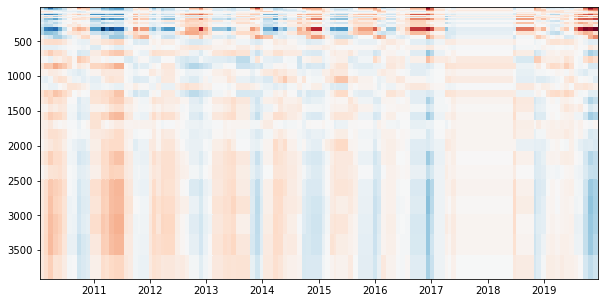

In [28]:
f, ax = plt.subplots(1,1,figsize=(10,5))
ax.pcolor(gobp2.time,depths,obp_all_d,cmap='RdBu_r')
ax.invert_yaxis()

In [22]:
# average all ECCO within GRACE mascons 
this_e_to_g = np.nan*np.ones(len(m_lon_2))
for i in range(len(m_lat_2)):
    indi = np.where(((lons+360) >= box[i,0]) & ((lons+360) <= box[i,1]) & (lats >= box[i,2]) & (lats <= box[i,3]) )
    this_e_to_g[i] = np.nanmean(gulf_a_obp[indi])

In [23]:
grace_ecco_grid = np.nan*np.ones((len(this_data.lat),len(this_data.lon)))
for i in range(500,600):
    for j in range(200,250):
        this_lon = this_data.lon[i].data
        this_lat = this_data.lat[j].data
        # does each lat/lon fall in a mascon
        for k in range(len(this_e_to_g)):
            if (this_lon > box[k,0]) & (this_lon < box[k,1]):
                if (this_lat > box[k,2]) & (this_lat < box[k,3]):
                    grace_ecco_grid[j,i] = this_e_to_g[k]

In [24]:
np.shape(grace_ecco_grid)
# np.shape(gobp_trend)

(360, 720)

In [26]:
gobp_trend_sub_mask = gobp_trend_sub*mask_val
gobp2_trend_sub_mask = gobp2_trend_sub*mask_val

gobp_trend_sub_anom = gobp_trend_sub_mask - gobp_trend_sub_mask.mean(dim=['lat','lon'])    # trend over period 1 (w/ GOM mean trend removed)
gobp2_trend_sub_anom = gobp2_trend_sub_mask - gobp2_trend_sub_mask.mean(dim=['lat','lon']) # trend over period 2 (w/ GOM mean trend removed)
print(gobp_trend_sub_mask.mean(dim=['lat','lon']).data)
print(gobp2_trend_sub_mask.mean(dim=['lat','lon']).data)

0.002906083067786789
0.0032030395034847946


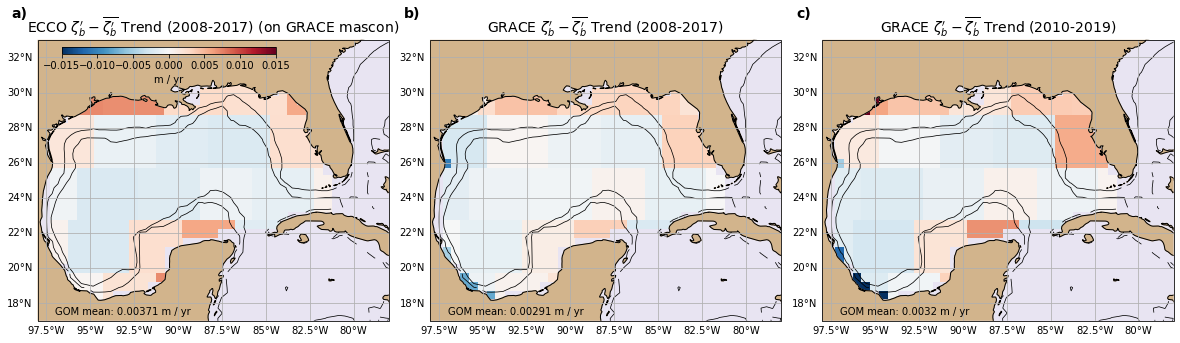

In [30]:
lon_w = -98; lon_e = -78; lat_s = 17; lat_n = 33; 
f, (ax0,ax,ax2) = plt.subplots(1,3,figsize=(16.5,5), subplot_kw={'projection':ccrs.PlateCarree(central_longitude=0)})

lat_in = np.where((grace.lat < 31) & (grace.lat >18))[0]
lon_in = np.where((grace.lon > (360-97.5)) & (grace.lon < (360-81)))[0]
grace_ecco_grid_sub = grace_ecco_grid[lat_in,:][:,lon_in]      

# ax0.pcolor(lons, lats, gulf_a_obp, transform=ccrs.PlateCarree(), vmin=-0.015, vmax=0.015, cmap=plt.get_cmap('RdBu_r')); ax.grid(); 
ax0.pcolor(grace.lon[lon_in],grace.lat[lat_in],\
           grace_ecco_grid_sub*mask_val, transform=ccrs.PlateCarree(), vmin=-0.015, vmax=0.015, cmap=plt.get_cmap('RdBu_r'));
ax0.contour(lons,lats,dep_t,levels=[150,1000],colors='k',transform=ccrs.PlateCarree(),linewidths=0.75)
ax0.text(-97,17.35,'GOM mean: ' + str(np.round(mean_gulf_trend,5)) + ' m / yr')
ax0.add_feature(cartopy.feature.LAND, color='#D2B48C',zorder=1); ax0.coastlines()
gl = ax0.gridlines(draw_labels=True); gl.ylabels_right = False; gl.xlabels_top = False;
ax0.set_xlim([lon_w, lon_e]); ax0.set_ylim([lat_s, lat_n])
ax0.set_facecolor('#e8e4f2');
ax0.set_title(r"ECCO $\zeta_b' - \overline{\zeta_b'}$ Trend (2008-2017) (on GRACE mascon)",fontsize=14)

# cc = gobp_trend_sub_anom.plot(ax=ax,transform=ccrs.PlateCarree(), vmin=-0.015, vmax=0.015, cmap=plt.get_cmap('RdBu_r'),add_colorbar=False)
cc = ax.pcolor(grace.lon[lon_in],grace.lat[lat_in], gobp_trend_sub_anom, \
          transform=ccrs.PlateCarree(), vmin=-0.015, vmax=0.015, cmap=plt.get_cmap('RdBu_r'))
ax.contour(lons,lats,dep_t,levels=[150,1000],colors='k',transform=ccrs.PlateCarree(),linewidths=0.75)
ax.text(-97,17.35,'GOM mean: ' + str(np.round(np.nanmean(gobp_trend_sub_mask.mean(dim=['lat','lon']).data),5)) + ' m / yr')
ax.set_title(r"GRACE $\zeta_b' - \overline{\zeta_b'}$ Trend (2008-2017)",fontsize=14)
ax.add_feature(cartopy.feature.LAND, color='#D2B48C',zorder=1); ax.coastlines()
gl = ax.gridlines(draw_labels=True); gl.ylabels_right = False; gl.xlabels_top = False;
ax.set_xlim([lon_w, lon_e]); ax.set_ylim([lat_s, lat_n])
ax.set_facecolor('#e8e4f2');

# cc = gobp2_trend_sub_anom.plot(ax=ax2,transform=ccrs.PlateCarree(), vmin=-0.015, vmax=0.015, cmap=plt.get_cmap('RdBu_r'),add_colorbar=False)
cc = ax2.pcolor(grace.lon[lon_in],grace.lat[lat_in], \
               gobp2_trend_sub_anom,transform=ccrs.PlateCarree(), vmin=-0.015, vmax=0.015, cmap=plt.get_cmap('RdBu_r'))
ax2.contour(lons,lats,dep_t,levels=[150,1000],colors='k',transform=ccrs.PlateCarree(),linewidths=0.75)
ax2.text(-97,17.35,'GOM mean: ' + str(np.round(np.nanmean(gobp2_trend_sub_mask.mean(dim=['lat','lon']).data),5)) + ' m / yr')
ax2.set_title(r"GRACE $\zeta_b' - \overline{\zeta_b'}$ Trend (2010-2019)",fontsize=14)
ax2.add_feature(cartopy.feature.LAND, color='#D2B48C',zorder=1); ax2.coastlines()
gl = ax2.gridlines(draw_labels=True); gl.ylabels_right = False; gl.xlabels_top = False;
ax2.set_xlim([lon_w, lon_e]); ax2.set_ylim([lat_s, lat_n])
ax2.set_facecolor('#e8e4f2');

ax0.text(-99.5,34.25,'a)',fontsize=14,fontweight='bold')
ax.text(-99.5,34.25,'b)',fontsize=14,fontweight='bold')
ax2.text(-99.5,34.25,'c)',fontsize=14,fontweight='bold')

# cbpos = [0.075, 0.88, 0.25, 0.02]; cax = f.add_axes(cbpos); 
# cb = f.colorbar(cc, cax=cax, orientation='horizontal', label='m / year')
# cbpos = [0.57, 0.88, 0.25, 0.02]; cax = f.add_axes(cbpos); 
# cb = f.colorbar(cc, cax=cax, orientation='horizontal', label='m / year')
cbpos = [0.055, 0.85, 0.18, 0.02]; cax = f.add_axes(cbpos); 
cb = f.colorbar(cc, cax=cax, orientation='horizontal', extend='neither', label='m / yr')
plt.tight_layout()
f.savefig('/Users/jakesteinberg/Documents/NASA_OSTST/manuscript/figures/grace_obp_trend.jpg', dpi=250)

In [229]:
np.nanmean(gobp2_trend_sub_mask)

0.0030618456692289566

In [18]:
gobp2_trend_sub_mask[:,0].data

array([        nan,         nan,         nan,         nan,         nan,
       -0.00855911,  0.00153552,  0.00153552,  0.00153552,  0.00146044,
        0.00146044,  0.00146044,  0.00146044,  0.00146044,  0.00146044,
               nan,  0.00471261,  0.00471261,  0.00471261,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan])

In [225]:
gobp_trend_sub_anom.lon.data

array([262.75, 263.25, 263.75, 264.25, 264.75, 265.25, 265.75, 266.25,
       266.75, 267.25, 267.75, 268.25, 268.75, 269.25, 269.75, 270.25,
       270.75, 271.25, 271.75, 272.25, 272.75, 273.25, 273.75, 274.25,
       274.75, 275.25, 275.75, 276.25, 276.75, 277.25, 277.75, 278.25,
       278.75])

In [224]:
grace.lon[lon_in].data

array([262.75, 263.25, 263.75, 264.25, 264.75, 265.25, 265.75, 266.25,
       266.75, 267.25, 267.75, 268.25, 268.75, 269.25, 269.75, 270.25,
       270.75, 271.25, 271.75, 272.25, 272.75, 273.25, 273.75, 274.25,
       274.75, 275.25, 275.75, 276.25, 276.75, 277.25, 277.75, 278.25,
       278.75])